# SECOND PART

## Importing datasets

In [168]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import seaborn as sns

echonest = pd.read_csv('data/datasets/echonest.csv')
features = pd.read_csv('data/datasets/features.csv')
tracks = pd.read_csv('data/datasets/tracks.csv')

In [2]:
# give a look to the data
'''
echonest
features
tracks
print(list(echonest.columns)[0:26])
print(list(features.columns)[0:26])
print(list(tracks.columns))
print(tracks.isnull().sum().to_string())

''';

Let's check if the dataset are subsets of each other before merging them together

In [3]:
track_set = set(tracks['track_id'])
echonest_set = set(echonest['track_id'])
features_set = set(features['track_id'])


In [4]:
print('is echonest subset of track?',echonest_set.issubset(track_set))
print('lenght of intersection between track and echonest:',len(track_set.intersection(echonest_set)))
print('lenght of echonest:',len(echonest_set))
print('track is equal to features?',track_set == features_set)

is echonest subset of track? True
lenght of intersection between track and echonest: 13129
lenght of echonest: 13129
track is equal to features? True


Ok, we can finally merge the datasets

In [5]:
temp = pd.merge(echonest, features, on = 'track_id')
df= pd.merge(temp, tracks, on = 'track_id')
df

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,NaN,20996,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,13365,NaN,8,NaN,[],I'm Wearing My Dancing Pants
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,NaN,4501,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,3588,NaN,9,NaN,[],Me Funky You Jane
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,NaN,3641,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,2956,NaN,10,NaN,[],Ain't Mad at Ya
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,NaN,3960,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,3126,NaN,11,NaN,[],This Is Not the End


In [6]:
df1=df

Now we can give a look to the new dataset

In [7]:
'''
for col in merged.columns:
    print(col)
''';


# Part 2.2: Choose your features (variables)

## Select one method for dimensionality reduction

Our choice is to perform an PCA 

GOAL: 
 1. reduce the dimensionality  keeping the features that preserve the most of the variance, which means to reduce the noise induced by the other features
 
LIMITATIONS: 
1. Low intepretability of principal features
2.  trade-off between dimensionality reduction and information loss

ASSUMPTIONS:
1. PCA assumes a correlation between features
2. PCA is sensitive to the scale of features
3. PCA is not robust to outliers
4. PCA assumes a linear relationship between features
5. The implementation requires no missing values

### Retrieve general informations about the data

In [8]:

df['track_title'] = df['track_title'].fillna('-')
df['track_language_code'] = df['track_language_code'].fillna('-')
df['metadata_artist_location'] = df['metadata_artist_location'].fillna('-')
df['artist_date_created'] = df['artist_date_created'].fillna('-')
df['album_type'] = df['album_type'].fillna('-')
df['metadata_artist_latitude'] = df['metadata_artist_latitude'].fillna('-')
df['metadata_artist_longitude'] = df['metadata_artist_longitude'].fillna('-')

Let's give a look to our dataframe and its proprerty

In [9]:
info = pd.DataFrame([df.columns, df.dtypes, df.isna().sum()], ['Column', 'dtype', 'NumOfNA']).T
info

,Column,dtype,NumOfNA
0,track_id,int64,0
1,audio_features_acousticness,float64,0
2,audio_features_danceability,float64,0
3,audio_features_energy,float64,0
4,audio_features_instrumentalness,float64,0
...,...,...,...
815,track_lyricist,object,13055
816,track_number,int64,0
817,track_publisher,object,12977
818,track_tags,object,0


We eliminate columns with Nan values

In [10]:
df.dropna(axis=1, how='any', inplace=True)
print('dataframe shape',df.shape)
df.describe()

dataframe shape (13129, 790)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,...,artist_comments,artist_favorites,artist_id,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,...,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,1.312900e+04,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761,0.321996,...,1.546119,19.630589,6303.865641,248580.807068,0.044558,249.013558,4.310305,3.784447e+03,2147.068703,5.608500
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028,0.114619,...,4.958391,66.047980,4974.103114,63834.230395,0.494095,207.268166,20.884705,3.396744e+04,9434.471644,6.108004
min,2.000000,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,12.753000,0.000010,0.000000,...,-1.000000,-1.000000,1.000000,-1.000000,0.000000,18.000000,0.000000,6.300000e+01,12.000000,0.000000
25%,12986.000000,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,95.967000,0.197321,0.254517,...,0.000000,2.000000,2203.000000,192000.000000,0.000000,156.000000,0.000000,6.700000e+02,299.000000,2.000000
50%,28097.000000,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,120.057000,0.417743,0.328672,...,0.000000,6.000000,5442.000000,256000.000000,0.000000,214.000000,1.000000,1.351000e+03,694.000000,4.000000
75%,45021.000000,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,145.318000,0.665575,0.414481,...,1.000000,15.000000,9288.000000,320000.000000,0.000000,282.000000,4.000000,2.948000e+03,1714.000000,8.000000
max,124911.000000,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,251.072000,0.999990,0.667799,...,68.000000,963.000000,20818.000000,448000.000000,37.000000,3033.000000,1482.000000,3.293557e+06,543252.000000,213.000000


Let's retrieve and collect some general informations before going to PCA 

In [11]:
gen_info = df.iloc[:, 761:]
gen_info['metadata_artist_location'] = df['metadata_artist_location']
gen_info['metadata_artist_latitude'] = df['metadata_artist_latitude']
gen_info['metadata_artist_longitude'] = df['metadata_artist_longitude']
gen_info['track_id'] = df['track_id']
gen_info = gen_info[[gen_info.columns[-1]]+list(gen_info.columns[:-1])]
gen_info

,track_id,album_comments,album_favorites,album_id,album_listens,album_tags,album_title,album_tracks,album_type,artist_comments,...,track_genres_all,track_interest,track_language_code,track_listens,track_number,track_tags,track_title,metadata_artist_location,metadata_artist_latitude,metadata_artist_longitude
0,2,0,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,...,[21],4656,en,1293,3,[],Food,"Georgia, US",32.6783,-83.223
1,3,0,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,...,[21],1470,en,514,4,[],Electric Ave,"Georgia, US",32.6783,-83.223
2,5,0,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,...,[21],1933,en,1151,6,[],This World,"Georgia, US",32.6783,-83.223
3,10,0,4,6,47632,[],Constant Hitmaker,2,Album,3,...,[10],54881,en,50135,1,[],Freeway,"Philadelphia, PA, US",39.9523,-75.1624
4,134,0,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,...,[21],1126,en,943,5,[],Street Music,"Georgia, US",32.6783,-83.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0,0,18862,55904,[],Do You Know The Word,14,Album,0,...,"[542, 21, 286, 15]",20996,-,13365,8,[],I'm Wearing My Dancing Pants,Netherlands,52.1082,5.32986
13125,124862,0,0,18862,55904,[],Do You Know The Word,14,Album,0,...,"[542, 21, 286, 15]",4501,-,3588,9,[],Me Funky You Jane,Netherlands,52.1082,5.32986
13126,124863,0,0,18862,55904,[],Do You Know The Word,14,Album,0,...,"[542, 21, 286, 15]",3641,-,2956,10,[],Ain't Mad at Ya,Netherlands,52.1082,5.32986
13127,124864,0,0,18862,55904,[],Do You Know The Word,14,Album,0,...,"[542, 21, 286, 15]",3960,-,3126,11,[],This Is Not the End,Netherlands,52.1082,5.32986


## Principal Component Analysis

Now let's focus on quantitative variables

In [12]:
sound_info = df.iloc[:, 1:761]
sound_info

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,metadata_artist_location,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,32.6783,"Georgia, US",...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,32.6783,"Georgia, US",...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,32.6783,"Georgia, US",...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,39.9523,"Philadelphia, PA, US",...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,32.6783,"Georgia, US",...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,52.1082,Netherlands,...,0.044130,0.017932,0.019123,11.869940,0.405273,0.049399,0.038086,0.000000,2.820800,0.042830
13125,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,52.1082,Netherlands,...,0.050790,0.019464,0.014612,4.255357,0.298828,0.040642,0.025391,0.000000,1.789954,0.040908
13126,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,52.1082,Netherlands,...,0.044322,0.018616,0.017603,7.419688,0.344727,0.047787,0.041504,0.001953,1.961021,0.035228
13127,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,52.1082,Netherlands,...,0.097448,0.020286,0.020809,5.421509,0.283691,0.049346,0.040039,0.000000,1.949840,0.035900


 Dropping the columns with non-numeric datatypes to be able to apply PCA

In [13]:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sound_info = sound_info.select_dtypes(include=numerics)
sound_info

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0.388990,0.386740,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0.388990,0.386740,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0.388990,0.386740,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,0.557339,0.614272,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0.388990,0.386740,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,0.430808,0.456871,...,0.044130,0.017932,0.019123,11.869940,0.405273,0.049399,0.038086,0.000000,2.820800,0.042830
13125,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,0.430808,0.456871,...,0.050790,0.019464,0.014612,4.255357,0.298828,0.040642,0.025391,0.000000,1.789954,0.040908
13126,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,0.430808,0.456871,...,0.044322,0.018616,0.017603,7.419688,0.344727,0.047787,0.041504,0.001953,1.961021,0.035228
13127,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,0.430808,0.456871,...,0.097448,0.020286,0.020809,5.421509,0.283691,0.049346,0.040039,0.000000,1.949840,0.035900


It's time for PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(.70)

scaling data

In [15]:

x = pca.fit_transform(sound_info)

In [16]:
new_sound_info = pd.DataFrame(x, columns=['audio_feature_' + str(i) for i in range(len(x[0]))])
new_sound_info['track_id'] = df['track_id']
new_sound_info

,audio_feature_0,audio_feature_1,audio_feature_2,track_id
0,-816.840302,1176.719466,-504.123434,2
1,-1425.837812,1711.007971,-82.848599,3
2,-989.397977,533.225066,-304.797940,5
3,-2165.351686,-200.771438,304.073508,10
4,2555.920203,-156.929590,-782.675081,134
...,...,...,...,...
13124,-1143.966342,1477.307094,-1025.390987,124857
13125,2422.445985,435.279049,-594.550025,124862
13126,-571.045206,1143.535935,-219.442621,124863
13127,-386.140867,754.660071,785.895160,124864


 We wanto to check if you reach > 70% of the toal variance

In [17]:
print(pca.explained_variance_ratio_)
# overall varience
print('variance obtained:',sum(pca.explained_variance_ratio_))

[0.4303487  0.20541179 0.1080277 ]
variance obtained: 0.7437881932076243


We can merge the dataset obtained with PCA with the one of general information

In [34]:
df = pd.merge(gen_info, new_sound_info, on='track_id')
df.isna().sum()
df.dtypes

track_id                       int64
album_comments                 int64
album_favorites                int64
album_id                       int64
album_listens                  int64
album_tags                    object
album_title                   object
album_tracks                   int64
album_type                    object
artist_comments                int64
artist_date_created           object
artist_favorites               int64
artist_id                      int64
artist_name                   object
artist_tags                   object
set_split                     object
set_subset                    object
track_bit_rate                 int64
track_comments                 int64
track_date_created            object
track_duration                 int64
track_favorites                int64
track_genres                  object
track_genres_all              object
track_interest                 int64
track_language_code           object
track_listens                  int64
t

We have achieved our goal by reducing the space to just 36 columns oh which 33 are general informations 

## Visual representation

In this section we implent the representation using the covariance matrix

To follow the hyphotesis, we remove Nan values

In [99]:

df1.dropna(axis=1, how='any', inplace=True)



In [100]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt

sound_info = df1.iloc[:, 1:761]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sound_info = sound_info.select_dtypes(include=numerics)
sound_info


,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0.388990,0.386740,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0.388990,0.386740,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0.388990,0.386740,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,0.557339,0.614272,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0.388990,0.386740,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,0.430808,0.456871,...,0.044130,0.017932,0.019123,11.869940,0.405273,0.049399,0.038086,0.000000,2.820800,0.042830
13125,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,0.430808,0.456871,...,0.050790,0.019464,0.014612,4.255357,0.298828,0.040642,0.025391,0.000000,1.789954,0.040908
13126,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,0.430808,0.456871,...,0.044322,0.018616,0.017603,7.419688,0.344727,0.047787,0.041504,0.001953,1.961021,0.035228
13127,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,0.430808,0.456871,...,0.097448,0.020286,0.020809,5.421509,0.283691,0.049346,0.040039,0.000000,1.949840,0.035900


In [101]:
#pca=PCA(0.7)
from sklearn.decomposition import PCA
pca=PCA()
x = pca.fit_transform(sound_info)
x

array([[-8.16840302e+02,  1.17671947e+03, -5.04123434e+02, ...,
         3.01880292e-10, -1.68728906e-08, -2.62315002e-17],
       [-1.42583781e+03,  1.71100797e+03, -8.28485990e+01, ...,
        -2.42348104e-08, -5.30491039e-09,  1.75182009e-17],
       [-9.89397977e+02,  5.33225066e+02, -3.04797940e+02, ...,
        -1.59234538e-08, -9.91809808e-09, -4.29200965e-18],
       ...,
       [-5.71045206e+02,  1.14353594e+03, -2.19442621e+02, ...,
        -4.38359810e-09, -1.46792415e-08,  1.86261383e-19],
       [-3.86140867e+02,  7.54660071e+02,  7.85895160e+02, ...,
        -1.40977906e-09, -2.11504541e-08, -3.86856080e-18],
       [ 7.04772461e+02, -3.48690824e+03, -1.60402288e+02, ...,
         1.33698096e-08, -2.25275230e-09,  5.77776181e-18]])

We retrieve the covariance matrix with out number of components (755)

In [102]:
covar_matrix = PCA(n_components = 755)

In [103]:
import numpy as np
covar_matrix.fit(x)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var#cumulative sum of variance explained with [n] features

array([43. , 63.5, 74.3, 83.5, 90.5, 92. , 93.4, 94.6, 95.6, 96.5, 97. ,
       97.4, 97.7, 98. , 98.3, 98.5, 98.7, 98.9, 99. , 99.1, 99.2, 99.3,
       99.4, 99.5, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99

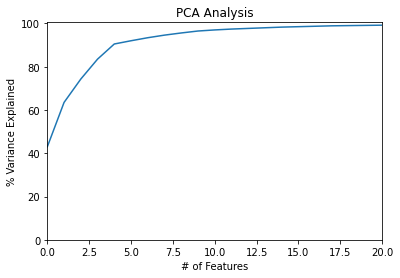

In [104]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.xlim([0, 20])
plt.style.context('seaborn-whitegrid')


plt.plot(var)

## 2.3 Clustering!
1. Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class.

2. Find an optimal number of clusters. Use at least two different methods. In case that your algorithms provide different optimal K's, select one of them and explain why you chose it.

3. Run the algorithm on the data that you got from the dimensionality reduction.

4. Then, use the already implemented version of k-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

In [207]:
def custom_kmeans(X, K, epsilon = 1/1000, maxIter = None):
    '''
    this function runs the kmeans algorithm on the dataset X
    searching for K clusters (labelled from  to K-1)

    Input: dataframe (for which the columns are the numerical features
            and the rows are the actual data points),
           number of clusters, parameter to control the convergence,
           maximum number of iterations to perform (if None, there will be no cap)

    Output: number of performed iterations, array of labels,
        centroids coordinates dataFrame, total cost of the solution
    '''
    
    should_Not_Stop = cycle_exit(epsilon, maxIter)
    
    npoints = len(X)
    
    ## random initialization
    # select a subset of points
    selected_points = np.random.choice(npoints, size=K, replace=False)
    # extract the centroids
    centroids = X.loc[selected_points].copy().reset_index(drop = True)
    
    # assign every point to the correct cluster
    labels = assign_cluster(X, centroids)
    
    # computing the cost of the initial solution
    cost = compute_cost(X,centroids, labels)
    
    
    # value to start the cycle
    previous_cost = cost + 1 + epsilon
    
    n_iter = 0
    while ( should_Not_Stop(cost, previous_cost, n_iter) ):
        n_iter += 1
        
        # update the centroids
        update_centroids(X,centroids, labels)
        
        # assign every point to the correct cluster
        labels = assign_cluster(X,centroids)
        
        # compute new cost
        previous_cost = cost
        cost = compute_cost(X,centroids, labels)

    return(n_iter, labels, centroids, cost)


def cycle_exit(epsilon, maxIter):
    '''
    function used to retrieve the correct function to be
    used for cycle exit evaluation
    '''

    def epsilon_function(cost, previous_cost, n_iter):
        exit = previous_cost - cost > epsilon
        return(exit)
    
    def iter_function(cost, previous_cost, n_iter):
        convergence = previous_cost - cost > epsilon
        iteration = n_iter <= maxIter
        return(convergence and iteration)


    if maxIter is not None:
        return (iter_function)
    else:
        return (epsilon_function)


def assign_cluster(X, centroids):
    '''
    this function assigns every data point in X
    and return the labels array
    '''
    K = len(centroids)
    npoints = len(X)
    nfeatures = X.shape[1]
    
    # we will use numpy methods to allow for faster computations
    # we will broadcast both X and the centroids to a 3D array of dimension (npoints, nfeatures, K)
    # in which the third dimension will represent the clusters
    broadcasting_shape = (npoints, nfeatures, K)
    
    # add the third dimension to the dataset and broadcast it
    broadcasted_X = X.values[:,:,np.newaxis]                                               # now the shape is (npoints, nfeatures, 1)
    broadcasted_X = np.broadcast_to(broadcasted_X, broadcasting_shape)                     # now the shape is (npoints, nfeatures, K)
    
    # transpose the centroids matrix and add a new dimension
    broadcasted_centroids = np.transpose(centroids.values)                                 # now the shape is          (nfeatures, K)
    broadcasted_centroids = broadcasted_centroids[np.newaxis,:,:]                          # now the shape is       (1, nfeatures, K)
    broadcasted_centroids = np.broadcast_to(broadcasted_centroids, broadcasting_shape)     # now the shape is (npoints, nfeatures, K)
    
    # here we compute the squared distance between every point and the centroid
    # the position (i,j) is the squared distance of the i-th point from the j-th centroid
    squared_distances = np.sum( (broadcasted_X - broadcasted_centroids)**2, axis=1)        # now the shape is (npoints, K)
    
    # here we take the argument which corresponds to the minimum distance
    labels = np.argmin(squared_distances, axis = 1)                                        # now the shape is  (npoints, )
    
    return (labels)

def update_centroids(X, centroids, labels):
    '''
    this function updates the centroids coordinates
    '''
    K = len(centroids)
    
    for i in range(K):
        centroids.loc[i] = X[labels == i].mean()
    
    return

def compute_cost(X, centroids, labels):
    '''
    computes the cost of a given solution
    '''
    
    K = len(centroids)
    
    cost = 0
    for i in range(K):
        # dataframe of squared differences
        squared_difference_vector = (X[labels == i] - centroids.loc[i])**2
        
        # we just add up every element of the matrix, since there is no square root to perform
        cost += np.sum(squared_difference_vector.values)

    return(cost)

def compute_silhouette(X, K, labels):
    '''
    computes the Silhouette score of a given solution
    
    input: dataset, number of clusters, labels
    '''
    
    npoints = len(X)
    
    # count the size of each cluster
    cluster_sizes = Counter(labels)
    
    array_score = []
    for i in range(npoints):
        # compute silhouette score of i-th data point
        array_score.append(silhouette_score(i, X, K, labels, cluster_sizes))
    
    # final silhouette score
    silhouette = np.array(array_score).mean()
    
    return(silhouette)
    
def silhouette_score(i, X, K, labels, cluster_sizes):
    '''
    computes the silhouette score for the i-th data point
    '''
    # cluster of che current data point
    current_cluster = labels[i]
    
    # get every other cluster
    every_other_cluster = list(range(K))
    every_other_cluster.remove(current_cluster)
    
    if cluster_sizes[current_cluster] == 1:
        return(0)
    
    a = silhouette_a(X.loc[i], X[labels == current_cluster], cluster_sizes[current_cluster])
    b = silhouette_b(X.loc[i], X[labels != current_cluster], labels[labels!= current_cluster], cluster_sizes, every_other_cluster)
    
    score = (b-a)/max(a,b)
    
    return(score)

def silhouette_a(data_point, X, size):
    '''
    computes the silhouette 'a' coefficient
    '''
    # compute distance between each point in the cluster and the current data point
    a_score = np.sum(np.linalg.norm( X-data_point , axis = 1))/(size-1)
    
    return(a_score)

def silhouette_b(data_point, X, labels, cluster_sizes, every_other_cluster):
    '''
    computes the silhouette 'b' coefficient
    '''
    #edge case
    if len(every_other_cluster) == 0:
        return(0)
    
    # first cluster
    cluster_idx = every_other_cluster[0]
    size = cluster_sizes[cluster_idx]
    temp_b_score = np.sum(np.linalg.norm( X[labels == cluster_idx] - data_point, axis = 1))/size
    
    final_b_score = temp_b_score
    
    for cluster_idx in every_other_cluster[1:]:
        size = cluster_sizes[cluster_idx]
        temp_b_score = np.sum(np.linalg.norm( X[labels == cluster_idx] - data_point, axis = 1))/size
        if temp_b_score < final_b_score:
            final_b_score = temp_b_score
    
    return(final_b_score)

def kmeans_plus_plus(X, K):
    '''
    this function runs the kmeans++ algorithm from sklearn on the dataset X
    searching for K clusters (labelled from  to K-1)

    Input: dataframe (for which the columns are the numerical features
            and the rows are the actual data points),
           number of clusters

    Output: number of performed iterations, array of labels,
        centroids coordinates dataFrame, total cost of the solution
    '''
    
    kmeans = KMeans(n_clusters=K)
    labels = kmeans.fit_predict(X)
    centroids = pd.DataFrame(kmeans.cluster_centers_)
    n_iter = kmeans.n_iter_
    cost = compute_cost(X, centroids, labels)
    
    return(n_iter, labels, centroids, cost)

def run_elbow_silhouette(X, K = 10):
    '''
    this function computes the cost and the silhouette coefficient for various
    cluster sizes and returns them as two arrays
    
    input: dataset, maximum number of clusters
    '''
    
    # initialize output array
    cost_array = []
    silhouette_array = []
    
    for i in tqdm(range(2,K)):
        n_iter, labels, centroids, cost = custom_kmeans(tobe_clustered, i)
        cost_array.append(cost)
        silhouette_array.append(compute_silhouette(tobe_clustered, i, labels))
    
    return(cost_array, silhouette_array)

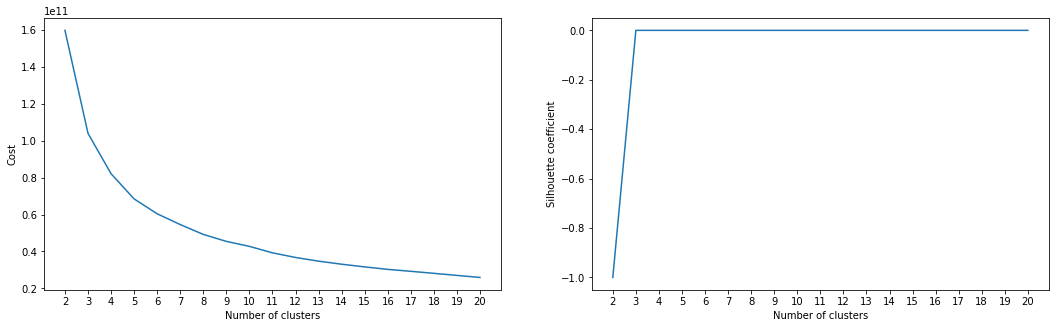

In [221]:
max_K = 10

# compute the cost and the silhouette coefficients
cost_array, silhouette_array = run_elbow_silhouette(X, max_K)

# plot them
fig, ax = plt.subplots(1,2, figsize = (18,5))

ax[0].plot(range(2,max_K), cost_array)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Cost')
ax[0].set_xticks(range(2,max_K))

ax[1].plot(range(2,max_K), silhouette_array)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette coefficient')
ax[1].set_xticks(range(2,max_K))

plt.show()

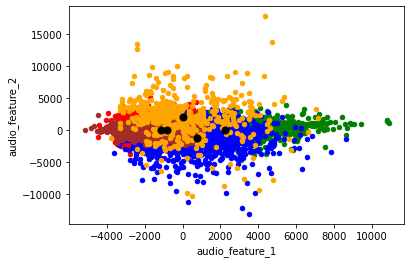

In [72]:
temp = tobe_clustered[['audio_feature_1', 'audio_feature_2']]
colori= ['red', 'green', 'blue', 'brown', 'orange']

fig, ax = plt.subplots()
for i in range(K):
    temp[labels == i].plot.scatter(*temp.columns, s=20, ax=ax, c=colori[i])
centroids.plot.scatter(*temp.columns, s=50, c='black', ax=ax)
plt.show()

In [84]:
centroids

,audio_feature_0,audio_feature_1,audio_feature_2
0,8005.462929,27.884717,2058.782230
1,-1872.919763,-806.658080,77.875933
2,-1127.345330,2252.889100,98.863806
3,786.284052,-1145.833943,45.593427
4,3431.901305,774.013489,-1136.695467


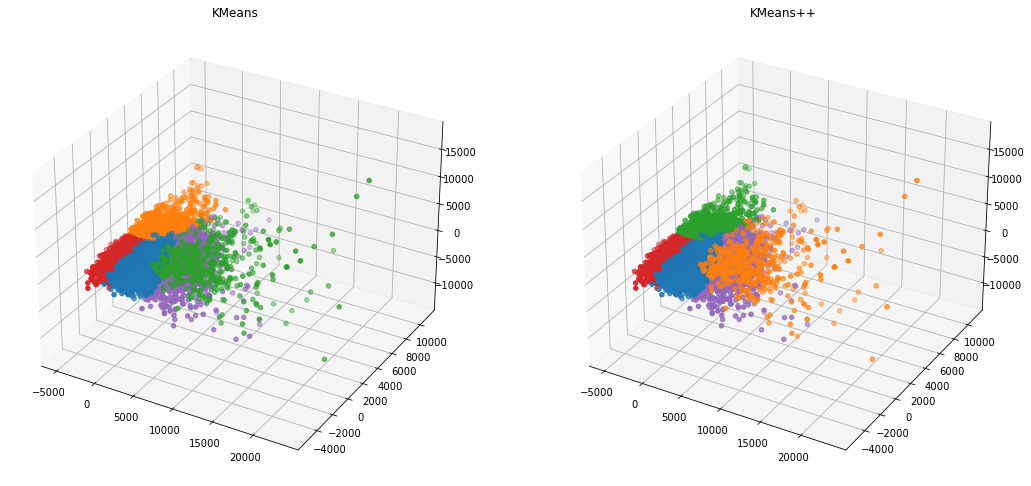

In [223]:
custom_n_iter, custom_labels, custom_centroids, custom_cost = custom_kmeans(tobe_clustered, K)
plus_plus_n_iter, plus_plus_labels, plus_plus_centroids, plus_plus_cost = kmeans_plus_plus(tobe_clustered, K)

def features_3dplot_comparison():
    '''
    plots the 3d
    '''
fig, ax = plt.subplots(1,2,figsize = (18,10), subplot_kw=dict(projection="3d"))

for i in range(K):
    custom_x = tobe_clustered[custom_labels == i]['audio_feature_0']
    custom_y = tobe_clustered[custom_labels == i]['audio_feature_1']
    custom_z = tobe_clustered[custom_labels == i]['audio_feature_2']
    
    plus_plus_x = tobe_clustered[plus_plus_labels == i]['audio_feature_0']
    plus_plus_y = tobe_clustered[plus_plus_labels == i]['audio_feature_1']
    plus_plus_z = tobe_clustered[plus_plus_labels == i]['audio_feature_2']
    
    ax[0].scatter(custom_x, custom_y, custom_z, s = 20)
    ax[1].scatter(plus_plus_x, plus_plus_y, plus_plus_z, s = 20)

ax[0].set_title('KMeans')
ax[1].set_title('KMeans++')

plt.show()

In [64]:
df['track_genres']

0              [21]
1              [21]
2              [21]
3              [10]
4              [21]
            ...    
13124    [286, 542]
13125    [286, 542]
13126    [286, 542]
13127    [286, 542]
13128       [5, 15]
Name: track_genres, Length: 13129, dtype: object

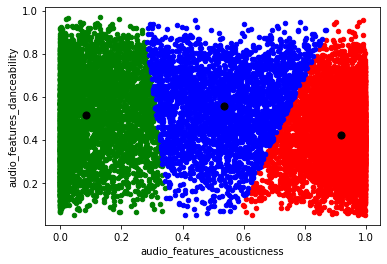

In [181]:
temp2 = temp[['audio_features_acousticness', 'audio_features_danceability']]
n_iter, labels, centroids, cost = custom_kmeans(temp2, 3)

colori= ['red', 'green', 'blue']

fig, ax = plt.subplots()
for i in range(3):
    temp2[labels == i].plot.scatter(*temp2.columns, s=20, ax=ax, c=colori[i]) 
centroids.plot.scatter(*temp2.columns, s=50, c='black', ax=ax)
plt.show()

In [ ]:
n_iter, labels, centroids, cost = custom_kmeans(tobe_clustered, K)

In [90]:
temp['labels'] = labels

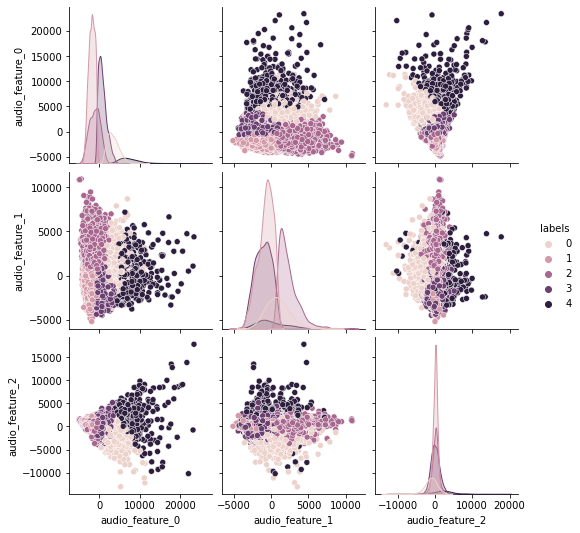

In [177]:
sns.pairplot(temp, hue = 'labels')